In [37]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.table as at
import astropy.units as u

In [4]:
tbl = at.QTable.read('data/hat-p-20.fits')

In [5]:
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body, get_moon
t = Time(tbl['BJD'][14],format='jd',scale='tdb')
loc = EarthLocation.of_site('apo') 
with solar_system_ephemeris.set('builtin'):
    earth_posvel = get_body('earth', t, loc) 
earth_posvel

<SkyCoord (GCRS: obstime=2456671.85989, obsgeoloc=(-3923680.51104034, 3661143.05206874, 3440582.68083093) m, obsgeovel=(-266.98500951, -286.46640594, 0.35765319) m / s): (ra, dec, distance) in (deg, deg, AU)
    (316.97619051, -32.66695934, 4.26122618e-05)>

In [6]:
import astropy.coordinates as coord

hatp20_c = coord.SkyCoord.from_name('HAT-P-20')
loc = coord.EarthLocation.of_site('APO')
ts = Time(tbl['BJD'], format='jd', scale='tdb')
bc = hatp20_c.radial_velocity_correction(obstime=ts, location=loc).to(u.km/u.s)

In [7]:
print(bc[0])

7.255264357409506 km / s


In [8]:
print(bc[35])

-26.24759103545591 km / s


In [26]:
import scipy.constants as const

def zplusone(vel):
    return np.sqrt((1 + vel/(const.c*u.m/u.s))/(1 - vel/(const.c*u.m/u.s)))

def shifts(vel):
    return (1/zplusone(vel)) - 1

\lambda_{emit} (z + 1) = \lambda_{observed}
\lambda_{emit} = 1/(z + 1) \lambda_{observed}
\log \lambda_{emit} = \log (1/(z + 1) \lambda_{observed})
\log \lambda_{emit} = \log (1/(z + 1)) + \log (\lambda_{observed})
\log \lambda_{emit} - \log (\lambda_{observed}) = \log (1/(z + 1))
\delta \log \lambda = \log (z + 1)


\lambda_{emit} - \lambda_{observed} = (1/(z + 1) - 1) \lambda_{observed}
\delta \lambda = (1/(z + 1) - 1) \lambda_{observed}

In [27]:
shift_z = shifts(bc)

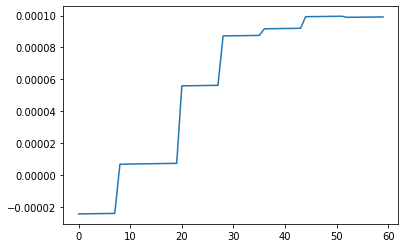

In [29]:
plt.plot(shift_z)
plt.show()

In [30]:
import loss as wobble_loss
import simulator as wobble_sim
import model as wobble_model
import jax.numpy as jnp


In [31]:
fluxes  = np.array(tbl['flux'])
lambdas = np.array(tbl['wavelength'])

In [32]:
print(lambdas.shape)

(60, 6144)


In [33]:
averages = np.average(lambdas,axis=1)

In [34]:
print(averages.shape)

(60,)


In [35]:
lamb_shift = np.multiply(averages, shift_z)

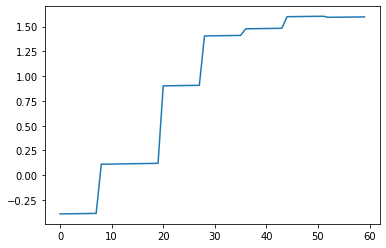

In [36]:
plt.plot(lamb_shift)

In [ ]:
def dataInterp(masks,flux):
    cnt = 0
    new_flux = flux[:]
    for i, mask in enumerate(masks):
        if mask != 0:
            cnt += 1
        if mask == 0 and cnt != 0:
            new_flux[i-cnt:i] = np.linspace(flux[i-cnt-1],flux[i],cnt+2)[1:-1]
            cnt = 0
            
    return new_flux